# 🎵 Spotify Tracks Dataset - Machine Learning

## Importing Libraries
- `pandas`, `numpy`: For data manipulation.
- `seaborn`, `matplotlib`: For plotting.
- `sklearn`: For preprocessing, dimensionality reduction, and modeling.
- `xgboost`: For gradient boosting classification.
- `tqdm`: For progress tracking in loops.
- `umap`: For advanced dimensionality reduction and visualization.
- `requests`: For optional interaction with Spotify's API.

In [ ]:
import requests

#import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

import xgboost as xgb

# Data Input and basic preprocessing

We load the Spotify Tracks dataset (from kaggle `maharshipandya/-spotify-tracks-dataset` or `dataset.csv`) and remove duplicates based on `track_name` and `artists`.

In [9]:
#path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

In [10]:
#df_full = pd.read_csv(path + "\\Dataset.csv", index_col=0).drop_duplicates(subset=['track_name', 'artists'])

df_full = pd.read_csv("dataset.csv", index_col=0).drop_duplicates(subset=['track_name', 'artists'])

df_full.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,release_date,release_year
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,2022-04-08,2022
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2021-04-30,2021
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,2021-03-17,2021
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,2018-08-10,2018
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,2017-02-03,2017


In [11]:
#Add release date to dataset

'''release_dates = []
tracks = []
TOKEN = ""
header = {"Authorization" : f"Bearer  {TOKEN}"}
for id in tqdm(df_full['track_id']):
    if len(tracks) < 50:
        tracks.append(id)
        continue
    tracks.append(id)
    resp = requests.get(f"https://api.spotify.com/v1/tracks?ids={','.join(tracks)}", headers=header)
    for x in resp.json()['tracks']:
        release_dates.append(x['album']['release_date'])
    tracks = []

resp = requests.get(f"https://api.spotify.com/v1/tracks?ids={','.join(tracks)}", headers=header)
for x in resp.json()['tracks']:
    release_dates.append(x['album']['release_date'])

df_full['release_date'] = release_dates
df_full.to_csv('dataset.csv', index=True)'''


'release_dates = []\ntracks = []\nTOKEN = ""\nheader = {"Authorization" : f"Bearer  {TOKEN}"}\nfor id in tqdm(df_full[\'track_id\']):\n    if len(tracks) < 50:\n        tracks.append(id)\n        continue\n    tracks.append(id)\n    resp = requests.get(f"https://api.spotify.com/v1/tracks?ids={\',\'.join(tracks)}", headers=header)\n    for x in resp.json()[\'tracks\']:\n        release_dates.append(x[\'album\'][\'release_date\'])\n    tracks = []\n\nresp = requests.get(f"https://api.spotify.com/v1/tracks?ids={\',\'.join(tracks)}", headers=header)\nfor x in resp.json()[\'tracks\']:\n    release_dates.append(x[\'album\'][\'release_date\'])\n\ndf_full[\'release_date\'] = release_dates\ndf_full.to_csv(\'dataset.csv\', index=True)'

# Column Description
- **track_id:** The Spotify ID for the track
- **artists:** The artists' names who performed the track. If there is more than one artist, they are separated by a ;
- **album_name:** The album name in which the track appears
- **track_name:** Name of the track
- **popularity:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
- **duration_ms:** The track length in milliseconds
- **explicit:** Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
- **danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
- **energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
- **loudness:** The overall loudness of a track in decibels (dB)
- **mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
- **speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
- **acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
- **instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
- **liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
- **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
- **tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
- **time_signature:** An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
- **track_genre:** The genre in which the track belongs

# Data cleaning

We explore data types and missing values, drop irrelevant or unreliable columns (time_signature), and fix release_year parsing from the release date.

In [12]:
df_full.dtypes

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
release_date         object
release_year          int64
dtype: object

In [13]:
#We can ignore theese missing values, we will not use theese variables for classification anyway
df_full.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
release_date        0
release_year        0
dtype: int64

In [14]:
#This variable is very noisy, and mostly incorrect
df_full = df_full.drop(columns=['time_signature']);

In [15]:
df_full['release_year'] = df_full['release_date'].str[:4].astype('int64')

In [16]:
df_full.loc[:, ['release_year', 'track_id']].groupby('release_year').count().sort_values('release_year')

,track_id
release_year,
0,158
1905,2
1913,1
1923,1
1925,7
...,...
2021,7501
2022,14482
2023,73


In [17]:
#We drop dataset columns where year value is missing
df_full = df_full.loc[df_full['release_year'] != 0]

We discovered that:
- Some `release_year` entries were incorrect (like 0), so we removed those.
- `time_signature` was noisy, not correct and deemed not useful for classification.

# The loudness war
**The loudness war** is, according to Wikipedia "trend of increasing audio levels in recorded music, which reduces audio fidelity and—according to many critics—listener enjoyment". According to many it was mainly visible in the late 90s, and early 00s. We can verify the existance of such phenomenon on our data. The plot shows the mean loudness of tracks across the years smoothed out by rolling window mean method

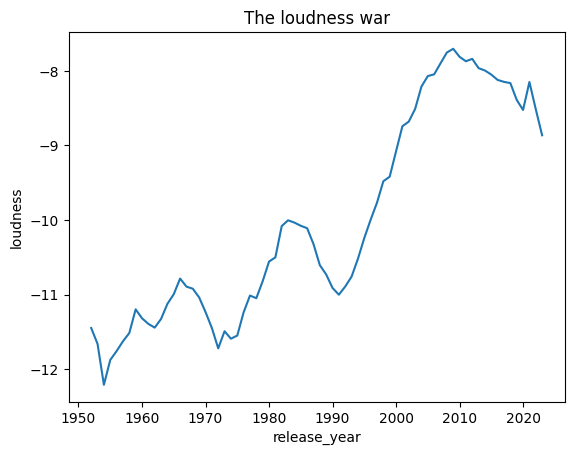

In [19]:
sns.lineplot(df_full.loc[df_full['release_year'] >= 1950].groupby('release_year')['loudness'].mean().rolling(window=5, center=True).mean().reset_index(), 
             x='release_year', 
             y='loudness',
             ).set_title("The loudness war");

# Exploratory Data Analysis (EDA)
Before modeling, we explore some trends and patterns across selected genres.

In [20]:
df_full.loc[:, 'track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

### Selected Genres
Due to the large number of genres (>100), we focus on a subset of 12 that are diverse and well-represented:

In [21]:
genres_subset = ['singer-songwriter', 'death-metal', 'hard-rock', 'blues', 'hip-hop', 'country', 'folk', 'black-metal', 'rock', 'alternative', 'pop', 'psych-rock']

We reduce the dataset to only include tracks within these genres and reset the index.

In [22]:
df_full = df_full.loc[lambda df: df['track_genre'].isin(genres_subset)].reset_index(drop=True)
NUM_OF_CLASSES = len(genres_subset)

### Genre Distribution
Now we check the number of tracks per genre:

In [23]:
df_full.loc[:, ['track_genre', 'track_id']].groupby('track_genre').count().sort_values('track_id').rename(columns={"track_id": "count"})

,count
track_genre,
rock,167
alternative,238
pop,289
singer-songwriter,430
psych-rock,550
country,570
hard-rock,626
hip-hop,645
blues,686


### Acousticness by Genre

In [25]:
df_full.loc[:, ['track_genre', 'acousticness']].groupby('track_genre').mean().sort_values('acousticness', ascending=False)

,acousticness
track_genre,
singer-songwriter,0.571864
folk,0.484270
pop,0.382901
psych-rock,0.342094
blues,0.327319
country,0.299410
hip-hop,0.222678
rock,0.211643
alternative,0.181499


Genres like singer-songwriter and folk have the highest acousticness, while genres like death-metal are almost completely non-acoustic:

## Data Preparation for Modeling
We now prepare the dataset:
- Drop unnecessary columns like track_id, artists, and track_name.
- Encode the genre labels numerically using `LabelEncoder`.

In [26]:
df = df_full.drop(['track_id', 'artists', 'album_name', 'release_date', 'track_name'], axis=1)

In [27]:
label_encoder=LabelEncoder()

In [28]:
df['track_genre']=label_encoder.fit_transform(df['track_genre'])

df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,release_year
0,79,204763,True,0.870,0.523,1,-8.052,0,0.0602,0.43300,0.000021,0.1130,0.319,110.020,0,2021
1,86,168601,True,0.695,0.540,4,-5.692,1,0.0493,0.29900,0.000000,0.3670,0.415,121.932,0,2021
2,81,162680,True,0.773,0.470,2,-7.930,1,0.0299,0.01530,0.000193,0.0851,0.399,94.995,0,2020
3,85,216880,False,0.556,0.864,3,-5.870,0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,0,2000
4,83,185586,False,0.496,0.863,9,-4.153,1,0.0381,0.00460,0.000000,0.6390,0.243,110.018,0,2003


In [29]:
df_num = df.drop(columns=['track_genre'])

## Correlation Analysis

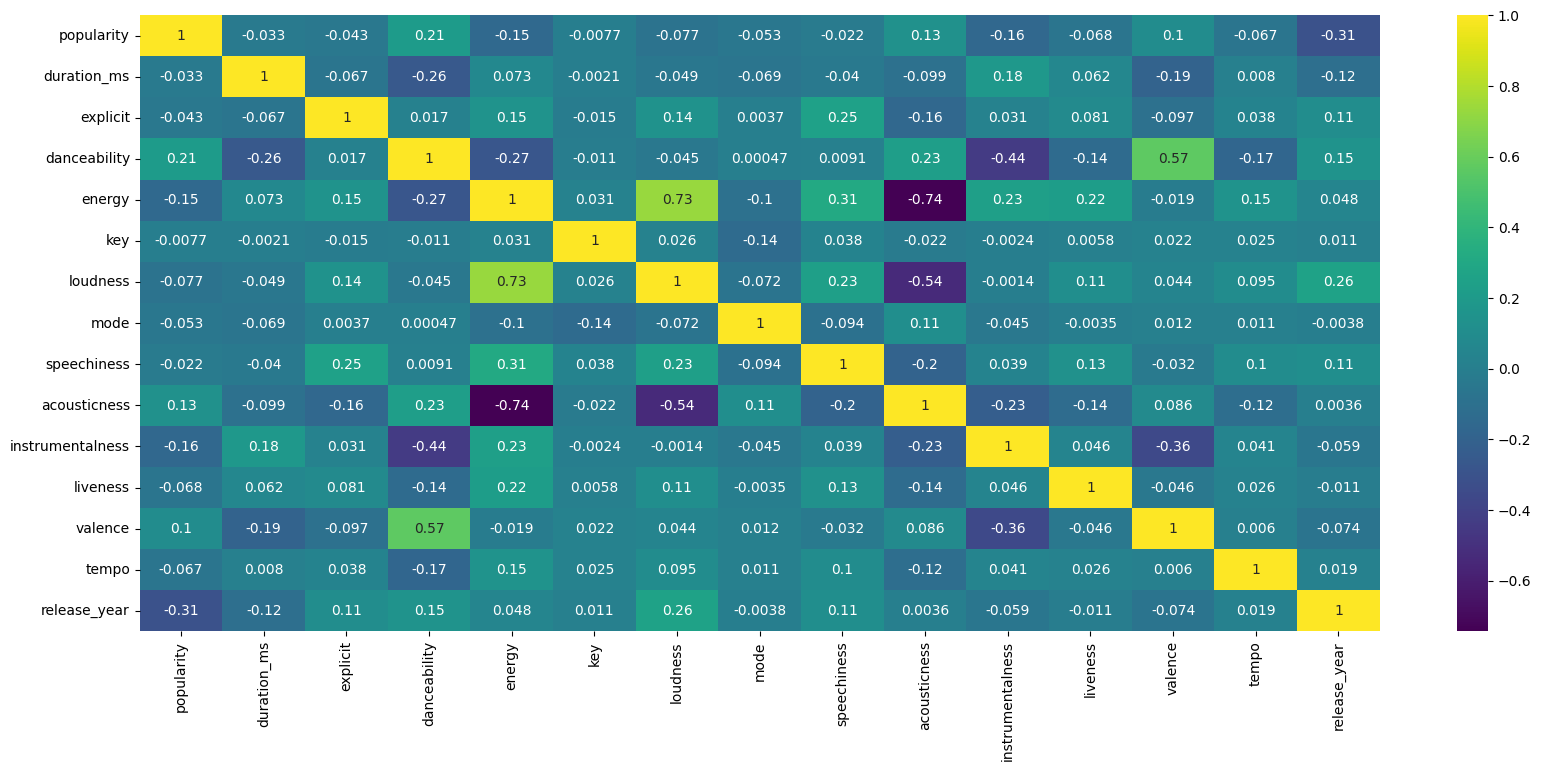

In [30]:
cor=df_num.corr()
plt.figure(figsize=(20,8))
sns.heatmap(cor, annot=True, cmap='viridis')
plt.show()

This heatmap shows how features correlate with each other. For example:
- loudness and energy tend to correlate strongly.
- acousticness and energy are likely inversely related.

# Feature Distribution by Genre
Using violin plots, we compare feature distributions across genres to understand genre-specific characteristics. Each plot shows the distribution (shape, spread, center) of a feature for all 12 genres.

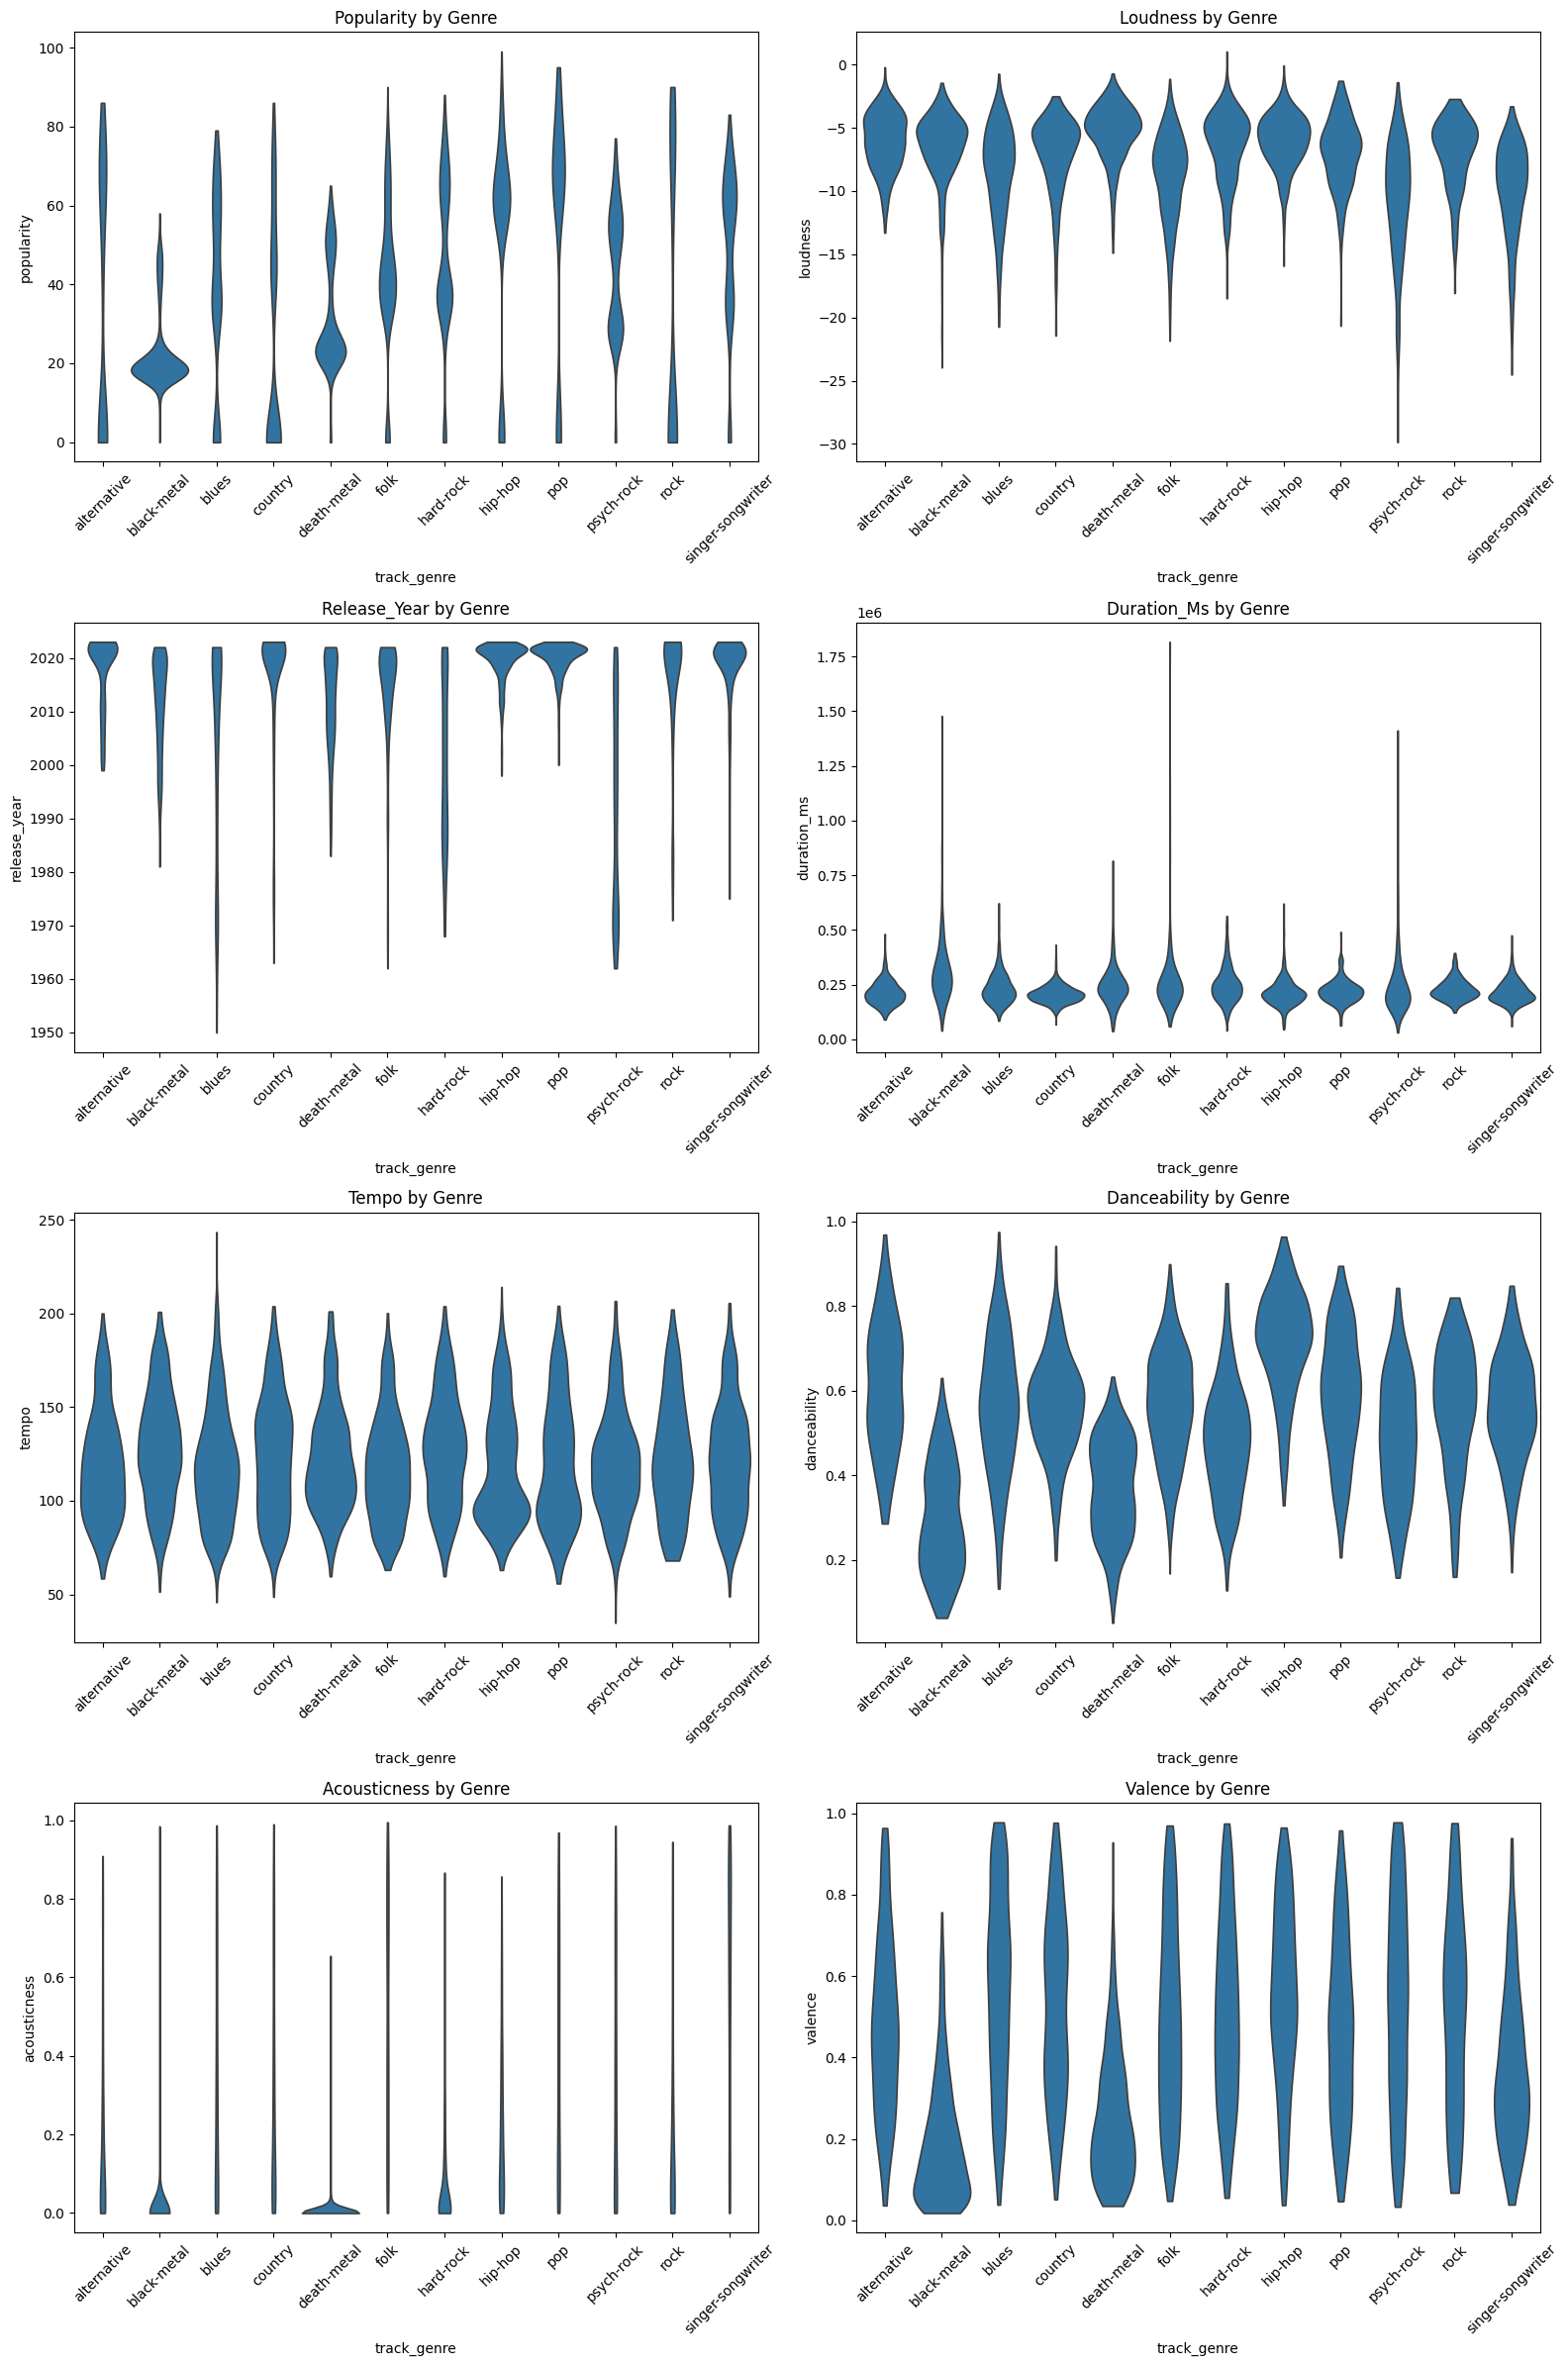

In [31]:
features = ['popularity', 'loudness', 'release_year', 'duration_ms', 'tempo', 'danceability', 'acousticness', 'valence']

# Create subplots
fig, axes = plt.subplots(nrows=int(len(features) / 2), ncols=2, figsize=(16, 24))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(df_full, x='track_genre', y=feature, inner=None, cut=0, width=1, ax=axes[i])
    axes[i].set_title(f'{feature.title()} by Genre')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Most Popular Tracks per Genre
We display the most popular song in each genre:

In [32]:
pd.DataFrame(df_full.loc[df_full.groupby('track_genre').idxmax().loc[:, 'popularity'].tolist()].loc[:, ['artists', 'track_name', 'popularity', 'track_genre']])

,artists,track_name,popularity,track_genre
1,GAYLE,abcdefu,86,alternative
239,Make Them Suffer,Doomswitch,58,black-metal
1230,Cage The Elephant,Cigarette Daydreams,79,blues
2237,Morgan Wallen,You Proof,86,country
2492,Slayer,Raining Blood,65,death-metal
3376,Seafret,Atlantis,90,folk
4094,Ghost,Mary On A Cross,88,hard-rock
5199,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52",99,hip-hop
5381,Harry Styles,As It Was,95,pop
5654,Pink Floyd,Wish You Were Here,77,psych-rock


# Feature Engineering & Model Comparison
In this section, we evaluate three classifiers on the same dataset:
- **Random Forest Classifier**
- **XGBoost Classifier**
- **Naive Bayes Classifier**

Each model is trained on the original dataset (80% train, 20% test, seed = 42), and performance is assessed using accuracy and F1 scores (per class).

In [35]:
scaler = StandardScaler()
norm_df = df.copy()
norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']] = scaler.fit_transform(df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']])

C:\Users\pawel\AppData\Local\Temp\ipykernel_17736\1148918695.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.68744559 1.97783089 1.77041282 ... 0.15255186 0.15255186 0.89925692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']] = scaler.fit_transform(df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']])
C:\Users\pawel\AppData\Local\Temp\ipykernel_17736\1148918695.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.37102632 -0.69309259 -0.74582624 ...  0.20423451 -0.41981452
 -0.61959857]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']] = scaler.f

### Data Splitting
We begin by splitting the normalized dataset into training and test sets using `train_test_split`. This will be used for fair model evaluation.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(norm_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=42)

In [37]:
X_train

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_year
2488,0.816290,-0.200294,False,0.158,0.572,0.467220,0.315049,0,0.0346,0.000926,0.893000,0.1440,0.3470,-1.442919,-0.871707
4461,1.065191,0.080189,False,0.414,0.897,-0.096278,0.282605,0,0.0538,0.000402,0.000002,0.0809,0.2630,1.616377,-1.972389
6544,1.645962,-0.045567,False,0.527,0.942,-1.223273,0.502533,0,0.0366,0.011500,0.000000,0.1880,0.4950,0.876297,-1.834804
4771,1.314093,-0.762356,False,0.908,0.314,-1.505022,-0.638449,1,0.1160,0.042400,0.000041,0.0727,0.2440,-0.848167,0.710523
3135,-0.677120,-0.497049,False,0.454,0.987,0.748969,0.931190,1,0.1100,0.000006,0.663000,0.2840,0.0619,0.250898,0.160182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.650355,-0.174039,False,0.472,0.468,-0.096278,-0.038386,1,0.0281,0.166000,0.000161,0.1460,0.3860,0.385222,0.091390
5191,0.857773,-0.444120,False,0.655,0.629,-1.223273,0.045738,1,0.0415,0.001090,0.063000,0.0752,0.1930,0.317493,0.297768
5226,0.816290,0.191659,False,0.431,0.794,0.185471,0.462337,0,0.4280,0.075900,0.000000,0.8500,0.4480,-1.581245,0.366560
5390,1.397060,-0.088940,False,0.605,0.530,1.594216,0.299832,1,0.0246,0.821000,0.000000,0.1310,0.3970,-0.950244,0.572938


#### PCA visualization of data

C:\Users\pawel\AppData\Local\Temp\ipykernel_17736\3472283856.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)


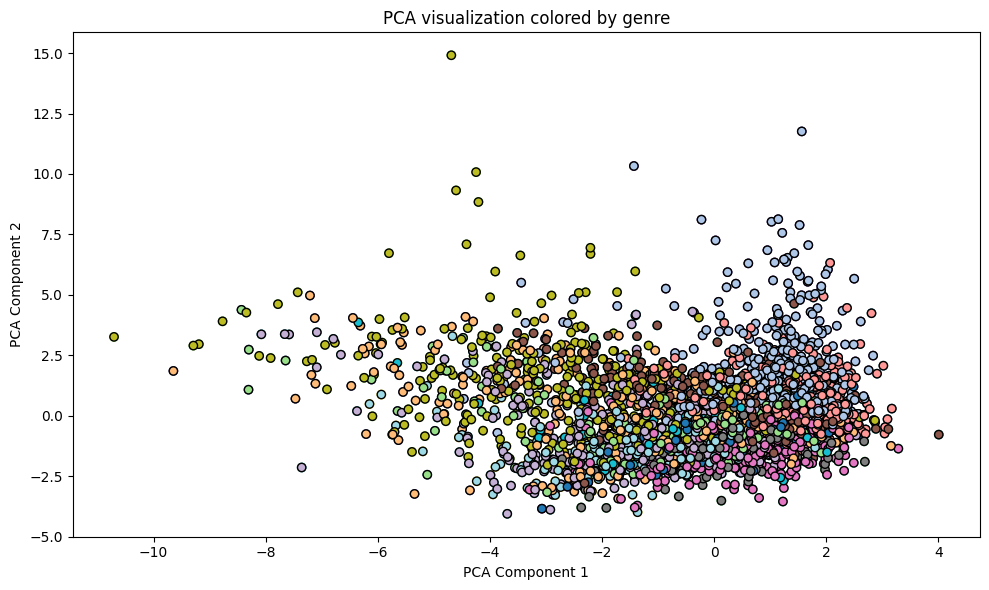

In [71]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y_train)
cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap=cmap, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA visualization colored by genre")
plt.tight_layout()
plt.show()

### Random Forest Classifier
A baseline model using `RandomForestClassifier`. This is a good starting point as it's robust to noise and gives us an initial idea of achievable performance.

A **Random Forest** is an ensemble of decision trees. It reduces overfitting and increases accuracy by averaging multiple deep decision trees trained on different parts of the dataset.

<p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/0*Ga2SY3cwKnkCRCTZ.jpg" alt="Random Forest Diagram" width="600"/>
</p>

**Key Parameters Used:**

- `random_state=0`: Ensures reproducibility of results by fixing the randomness.
- Other defaults (e.g., `n_estimators=100`, `max_depth=None`, `bootstrap=True`, etc.) are used.

> **Not used:** `bagSizePercent`, `batchSize`, `KernelEstimator`, `SupervisedDiscretization`  
> (These are Weka-specific parameters, not applicable in scikit-learn)

In [42]:
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train);

In [43]:
y_predict = classifier.predict(X_test)

In [44]:
print('Random forest classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

Random forest classifier performance:
Accuracy score: 0.6076414401175606
F1 score: [0.12307692 0.79318735 0.42145594 0.53811659 0.76426799 0.54711246
 0.62450593 0.71014493 0.37647059 0.59360731 0.05555556 0.52173913]


#### Boundary Visualizer

C:\Users\pawel\AppData\Local\Temp\ipykernel_17736\1597125341.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)


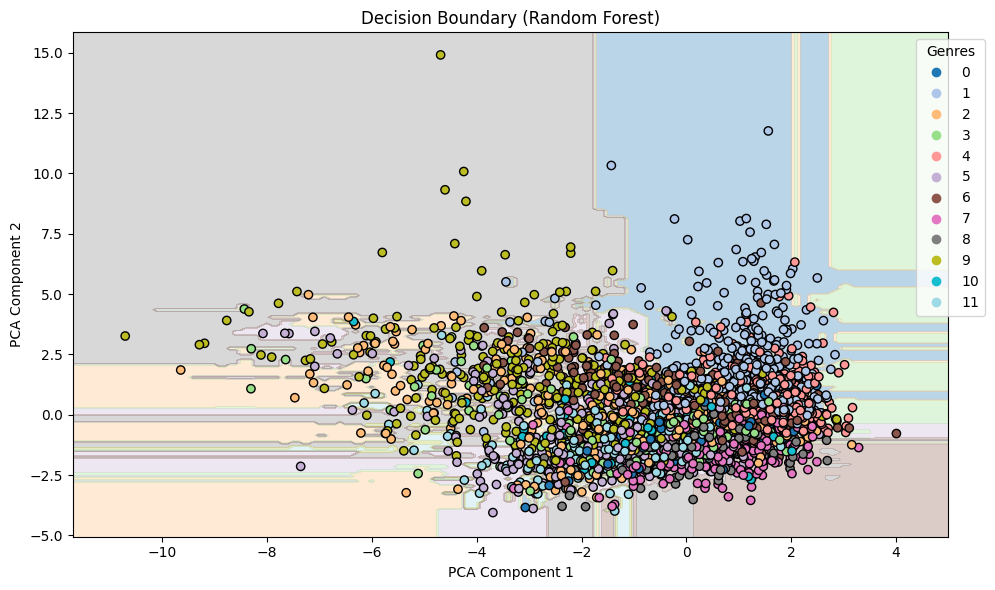

In [77]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_reduced, y_train)
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap=cmap, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary (Random Forest)")
plt.legend(*scatter.legend_elements(), title="Genres", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### XGBoost Classifier
We now try an `XGBClassifier`, which typically performs well on tabular datasets. Here we disable the label encoder and use `multi:softprob` for multiclass classification.

**XGBoost (Extreme Gradient Boosting)** is a powerful, regularized gradient boosting algorithm designed for speed and performance. It uses boosting (sequential learning) and handles multiclass classification efficiently.

XGBoost works by combining a number of weak learners to form a strong learner. A weak learner is a machine learning model that is only slightly better than random guessing. However, when weak learners are combined, they can form a strong learner!

XGBoost works by training a number of decision trees. Each tree is trained on a subset of the data, and the predictions from each tree are combined to form the final prediction.

<p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1000/0*zdmqFZ2nooBRedqC.png" alt="XGBClassifier Diagram" width="600"/>
</p>

**Key Parameters Used:**
* `objective='multi:softprob'`: Predicts probabilities for multi-class classification.
* `num_class=NUM_OF_CLASSES`: Number of genre classes.
* `eval_metric='mlogloss'`: Logarithmic loss used for evaluation.
* `use_label_encoder=False`: Avoids deprecated label encoder.
* Default `max_depth=6`, `learning_rate=0.3`, `n_estimators=100`, etc.


In [45]:
classifier = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss',     
    use_label_encoder=False
)
classifier.fit(X_train, y_train);

C:\Users\pawel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:20:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [46]:
y_predict = classifier.predict(X_test)

In [47]:
print('XGB classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

XGB classifier performance:
Accuracy score: 0.6171932402645114
F1 score: [0.28205128 0.81108312 0.48201439 0.51184834 0.79197995 0.50955414
 0.64541833 0.7265625  0.45098039 0.64864865 0.09302326 0.44444444]


We use XGBoost’s built-in feature importance plot to understand which features the model relies on most.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

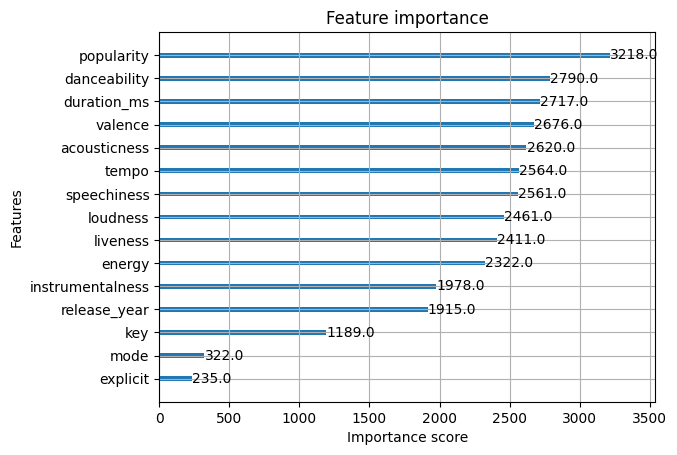

In [48]:
xgb.plot_importance(classifier)

#### Boundary Visualizer

C:\Users\pawel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [17:46:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\pawel\AppData\Local\Temp\ipykernel_17736\2185084741.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)


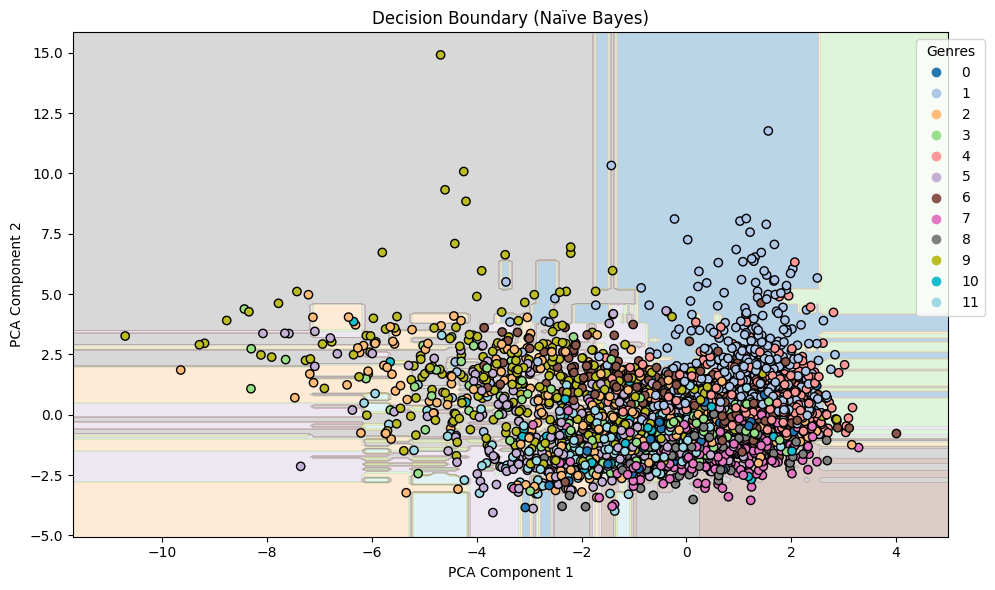

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
clf = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss',     
    use_label_encoder=False
)
clf.fit(X_reduced, y_train)
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap=cmap, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary (XGBoost)")
plt.legend(*scatter.legend_elements(), title="Genres", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### Naive Bayes Classifier
For comparison, we include a simple `GaussianNB` model. While it's unlikely to outperform the others, it gives us a useful lower-bound baseline.

Naive Bayes is a naive probabilistic classifier based on applying Bayes' theorem. It assumes feature independence and works well with high-dimensional data but often underperforms with complex correlations.

<p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1200/1*ZW1icngckaSkivS0hXduIQ.jpeg" alt="Naive Bayes Classifier Formula" height="400"/>
    <img src="https://pbs.twimg.com/media/EwxAgCsWgAEfkSp?format=jpg&name=4096x4096" alt="Naive Bayes Classifier Diagram" height="400"/>
</p>

**Key Parameters Used:**

* No special parameters were specified — all defaults were used:

  * `var_smoothing=1e-9`: Helps prevent division by zero in likelihood calculations.

In [49]:
classifier = GaussianNB()
classifier.fit(X_train, y_train);

In [50]:
y_predict = classifier.predict(X_test)

In [51]:
print('Naive Bayes classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

Naive Bayes classifier performance:
Accuracy score: 0.4342395297575312
F1 score: [0.14814815 0.5775076  0.23115578 0.3974359  0.64166667 0.27983539
 0.44736842 0.50190114 0.23448276 0.39252336 0.         0.42268041]


#### Boundary Visualizer

C:\Users\pawel\AppData\Local\Temp\ipykernel_17736\3004596856.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)


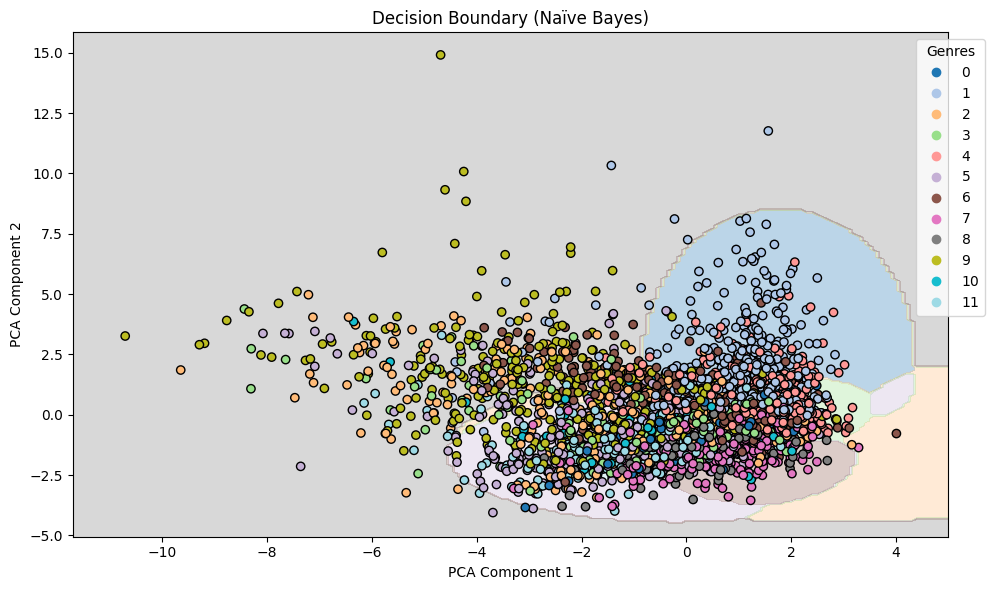

In [75]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
clf = GaussianNB()
clf.fit(X_reduced, y_train)
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
cmap = ListedColormap(plt.cm.get_cmap("tab20", len(np.unique(y_train))).colors)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap=cmap, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary (Naïve Bayes)")
plt.legend(*scatter.legend_elements(), title="Genres", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Feature engineering

### Derived Columns
We experiment with adding two engineered features:
- `valence_per_ms`: Valence per unit duration
- `idk`: Product of tempo and danceability

We then evaluate whether these features improve model performance.

In [52]:
# Adding some random columns
new_df = norm_df.copy()
new_df['valence_per_ms'] = new_df['valence'] / new_df['duration_ms']
new_df['idk'] = new_df['tempo'] * new_df['danceability']
new_df.loc[:, ['valence_per_ms', 'idk']] = scaler.fit_transform(new_df.loc[:, ['valence_per_ms', 'idk']])

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

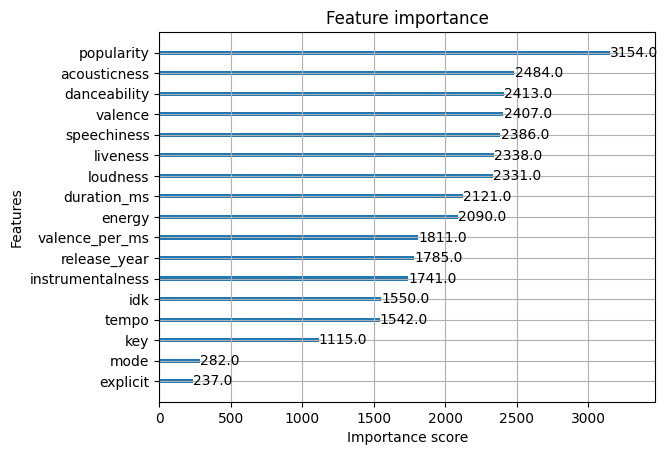

In [53]:
# Fitting XGBoost to the new dataframe
classifier = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss'
)
X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=42)
classifier.fit(X_train, y_train)
xgb.plot_importance(classifier)

We notice that XGBoost does not rely strongly on our new features.

### Performance Comparison (With vs Without New Features)
We now test the model using seeds 41–50 to ensure robustness and compare accuracy before and after adding new features.

In [57]:
# Comparison with the previous dataframe
print("Seed | Old acc | New acc")
total_diff = 0
acc_old = []
acc_new = []
for seed in [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]:
    X_train, X_test, y_train, y_test = train_test_split(norm_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc1 = accuracy_score(y_test, y_predict)

    X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc2 = accuracy_score(y_test, y_predict)

    total_diff += (acc2 - acc1)

    acc_old.append(acc1)
    acc_new.append(acc2)
    print(f" {seed}  | {f"{acc1:.5f}"} | {f"{acc2:.5f}"}")
print("Average Difference:", total_diff/10)

Seed | Old acc | New acc
 41  | 0.63850 | 0.62307
 42  | 0.61719 | 0.61940
 43  | 0.61719 | 0.61572
 44  | 0.63483 | 0.63262
 45  | 0.63336 | 0.64071
 46  | 0.62307 | 0.62748
 47  | 0.62895 | 0.62675
 48  | 0.63336 | 0.63189
 49  | 0.61425 | 0.61940
 50  | 0.64144 | 0.62968
Average Difference: -0.001542983100661266


### Accuracy Across Seeds – Visualization
This plot shows how accuracy varies with different random seeds for both the original and feature-engineered datasets. It helps visualize the consistency and overall performance impact of added features.

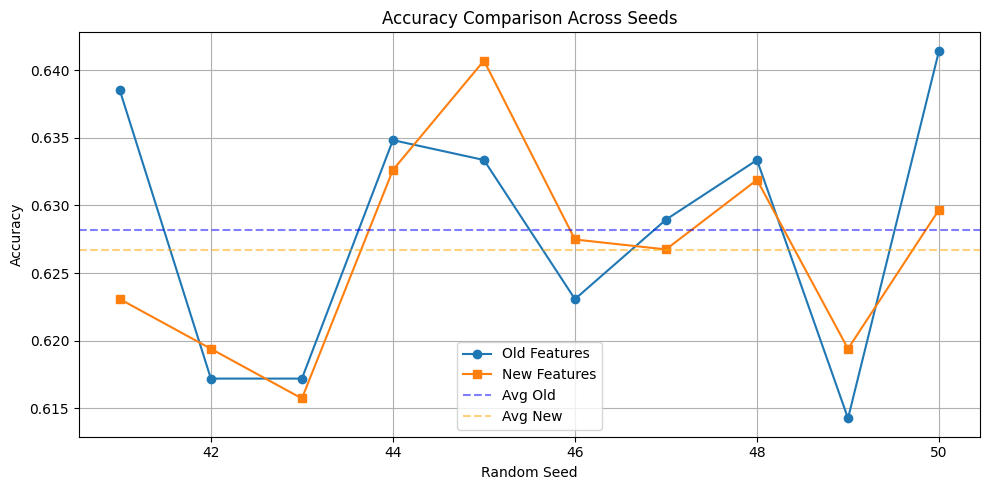

In [58]:
seeds = list(range(41, 51))
plt.figure(figsize=(10, 5))
plt.plot(seeds, acc_old, marker='o', label='Old Features')
plt.plot(seeds, acc_new, marker='s', label='New Features')
plt.axhline(y=sum(acc_old)/len(acc_old), color='blue', linestyle='--', alpha=0.5, label='Avg Old')
plt.axhline(y=sum(acc_new)/len(acc_new), color='orange', linestyle='--', alpha=0.5, label='Avg New')
plt.title('Accuracy Comparison Across Seeds')
plt.xlabel('Random Seed')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations
- Average performance dropped slightly after adding the two new features (`-0.00808` accuracy on average).
- Feature engineering is sensitive - arbitrary features may introduce noise or redundancy.

# Feature Pair Search: Multiplicative Combinations
In this section, we systematically explore combinations of numerical features by multiplying pairs and checking which new features improve model accuracy the most.
We exclude categorical and discrete columns like `explicit`, `mode`, `key`, and `tempo`, and test each pair across multiple random seeds to reduce noise in performance metrics.

In [56]:
# Trying to find the best new columns to add
scores = {}
columns = norm_df.columns.drop(["track_genre", "explicit", "mode", "key", "tempo"])
for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns[i+1::]):
        print(col1, "*", col2)
        new_df = norm_df.copy()
        new_df["new"] = new_df[col1] * new_df[col2]
        new_df.loc[:, ['new']] = scaler.fit_transform(new_df.loc[:, ['new']])

        acc = 0
        for seed in [41, 42, 43]:
            X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
            classifier.fit(X_train, y_train)
            y_predict = classifier.predict(X_test)
            acc2 = accuracy_score(y_test, y_predict)

            acc += acc2
        scores[(col1, col2)] = acc/3

popularity * duration_ms
popularity * danceability
popularity * energy
popularity * loudness
popularity * speechiness
popularity * acousticness
popularity * instrumentalness
popularity * liveness
popularity * valence
popularity * release_year
duration_ms * danceability
duration_ms * energy
duration_ms * loudness
duration_ms * speechiness
duration_ms * acousticness
duration_ms * instrumentalness
duration_ms * liveness
duration_ms * valence
duration_ms * release_year
danceability * energy
danceability * loudness
danceability * speechiness
danceability * acousticness
danceability * instrumentalness
danceability * liveness
danceability * valence
danceability * release_year
energy * loudness
energy * speechiness
energy * acousticness
energy * instrumentalness
energy * liveness
energy * valence
energy * release_year
loudness * speechiness
loudness * acousticness
loudness * instrumentalness
loudness * liveness
loudness * valence
loudness * release_year
speechiness * acousticness
speechiness *

The top 5 performing combinations based on average accuracy over 3 seeds are:

In [59]:
print(sorted(scores.items(), key = lambda x : -x[1])[:5:])

[(('danceability', 'speechiness'), 0.6235611070291452), (('loudness', 'release_year'), 0.6230712711241734), (('duration_ms', 'instrumentalness'), 0.6228263531716874), (('acousticness', 'valence'), 0.6228263531716874), (('popularity', 'loudness'), 0.6223365172667157)]


We then select the top 10 combinations to build a new feature-enhanced dataset, train the model again using `XGBoost`, and compare it to the baseline.

In [ ]:
new_cols = sorted(scores.keys(), key = lambda x : -scores[x])[:10:]
new_df = norm_df.copy()
for x1, x2 in new_cols:
    new_df[f"{x1}*{x2}"] = new_df[x1] * new_df[x2]
    new_df.loc[:, [f"{x1}*{x2}"]] = scaler.fit_transform(new_df.loc[:, [f"{x1}*{x2}"]])


In [61]:
classifier = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss'
)

Below is the comparison of model performance using original features vs. original + 10 best multiplicative features.
This allows us to verify if the engineered features provide consistent improvement across seeds:

Seed | Old acc | New acc
 41  | 0.63850 | 0.64217
 42  | 0.61719 | 0.60544
 43  | 0.61719 | 0.63336
 44  | 0.63483 | 0.64585
 45  | 0.63336 | 0.63409
 46  | 0.62307 | 0.62381
 47  | 0.62895 | 0.63777
 48  | 0.63336 | 0.64144
 49  | 0.61425 | 0.62748
 50  | 0.64144 | 0.65246
Average Difference: 0.006171932402645119


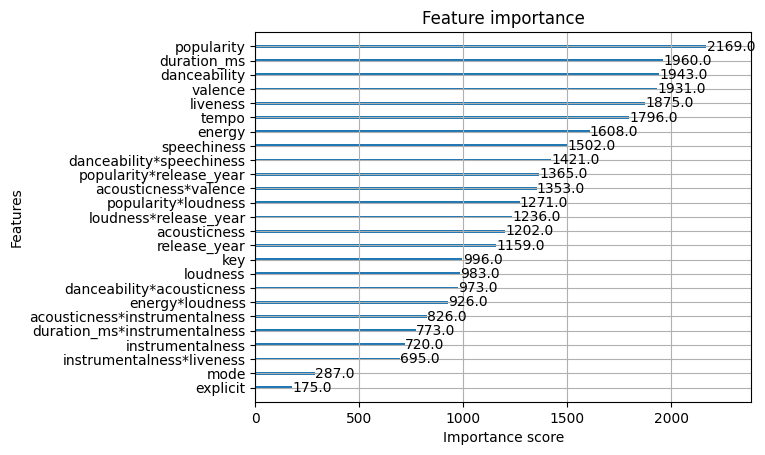

In [63]:
# Testing the new dataframe
print("Seed | Old acc | New acc")
total_diff = 0
acc_old = []
acc_new = []
for seed in [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]:
    X_train, X_test, y_train, y_test = train_test_split(norm_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc1 = accuracy_score(y_test, y_predict)

    X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc2 = accuracy_score(y_test, y_predict)

    total_diff += (acc2 - acc1)

    acc_old.append(acc1)
    acc_new.append(acc2)
    print(f" {seed}  | {f"{acc1:.5f}"} | {f"{acc2:.5f}"}")
    if seed == 49:
        xgb.plot_importance(classifier)
print("Average Difference:", total_diff/10)

We just gained +0.0062 (or 0.62%) average accuracy :)

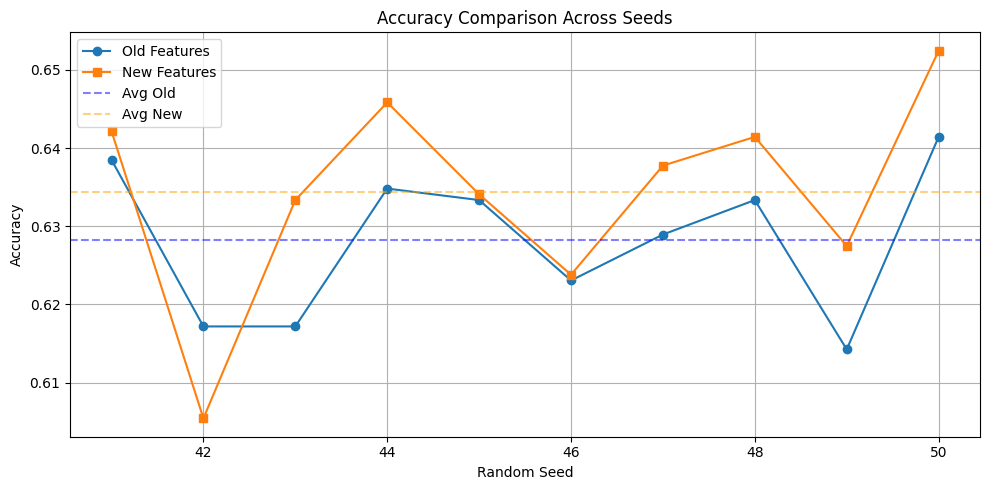

In [64]:
seeds = list(range(41, 51))
plt.figure(figsize=(10, 5))
plt.plot(seeds, acc_old, marker='o', label='Old Features')
plt.plot(seeds, acc_new, marker='s', label='New Features')
plt.axhline(y=sum(acc_old)/len(acc_old), color='blue', linestyle='--', alpha=0.5, label='Avg Old')
plt.axhline(y=sum(acc_new)/len(acc_new), color='orange', linestyle='--', alpha=0.5, label='Avg New')
plt.title('Accuracy Comparison Across Seeds')
plt.xlabel('Random Seed')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
